# Neural Architecture Search Lab

## Introduction
In this lab, we will apply hardware-aware neural architecture search to search for an accurate, robust, and noise-resilient architecture for analog in-memory computing using analogai-nas.

### Analog In-memory Computing

Analog in-memory computing (AIMC) is a promising computing paradigm that leverages the physical properties of emerging memory devices to perform certain computational tasks directly within the memory array itself. By exploiting the parallelism and high density of memory arrays, AIMC has the potential to significantly improve the energy efficiency and speed of various machine learning applications.

In deep learning inference, data propagation through multiple layers of a neural network involves a sequence of matrix multiplications, as each layer can be represented as a matrix of synaptic weights. On an Analog chip, these weights are stored in the conductance states of resistive devices such as PCM. The devices are arranged in crossbar arrays, creating an artificial neural network where all matrix multiplications are performed in-place in an analog manner. This structure allows inference to be performed using little energy with high areal density of synapses. An in-memory computing chip typically consists of multiple crossbar arrays of memory devices that communicate with each other (see figure below). A neural network layer can be implemented on (at least) one crossbar, in which the weights of that layer are stored in the charge or conductance state of the memory devices at the crosspoints.

<center><img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/analog_Dnn.png?raw=true" style="width:60%; height:60%"/></center>

### IBM Analog Hardware Acceleration Kit (AIHWKIT)

To simulate AIMC, we will use the IBM Analog Hardware Acceleration Kit (AIHWKIT).

AIHWKIT is an open source Python toolkit for exploring and using the capabilities of in-memory computing devices such as PCM in the context of artificial intelligence.
The pytorch integration consists of a series of primitives and features that allow using the toolkit within PyTorch.

The github repository can be found at: https://github.com/IBM/aihwkit

To learn more about Analog AI and the harware befind it, refer to this webpage: https://analog-ai-demo.mybluemix.net/hardware

### Hardware-aware Neural Architecture Search

Neural architecture search is a technique used to automate the design of neural networks. Instead of manually designing network architectures, NAS algorithms explore a search space of possible architectures and identify the most suitable ones based on predefined criteria such as accuracy, efficiency, or other performance metrics. NAS has gained significant attention in recent years due to its ability to discover novel network architectures that outperform handcrafted designs in various tasks.

In this lab, we will leverage the analogainas package.


### AnalogAINAS
[AnalogAINAS](https://github.com/IBM/analog-nas) is a framework that aims at building analog-aware efficient deep learning models. AnalogNAS is built on top of the [AIHWKIT](https://github.com/IBM/aihwkit). IBM Analog Hardware Acceleration Kit (AIHWKIT) is an open source Python toolkit for exploring and using the capabilities of in-memory computing devices in the context of artificial intelligence.

In a high-level AnalogAINAS consists of 4 main building blocks which (can) interact with each other:
* Configuration spaces: a search space of architectures targeting a specific dataset.
* Evaluator: a ML predictor model to predict:
    * 1-day Accuracy: the evaluator models the drift effect that is encountered in Analog devices. The accuracy after 1 day of drift is then predicted and used as an objective to maximize.
    * The Accuracy Variation for One Month (AVM): The difference between the accuracy after 1 month and the accuracy after 1 sec.
    * The 1-day accuracy standard deviation: The stochasticity of the noise induces different variation of the model's accuracy depending on its architecture.
* Optimizer: a optimization strategy such as evolutionary algorithm or bayesian optimization.
* Worker: A global object that runs the architecture search loop and the final network training pipeline



First, install the required packages.


In [1]:
!git clone https://github.com/IBM/analog-nas.git
%cd analog-nas
!python setup.py install

fatal: destination path 'analog-nas' already exists and is not an empty directory.
/content/analog-nas
Traceback (most recent call last):
  File "/content/analog-nas/setup.py", line 8, in <module>
    raise ValueError(
ValueError: Unsupported Python version 3.10.12 found. AnalogNAS requires Python 3.7, 3.8 or 3.9


In [2]:
!pip install aihwkit >/dev/null

### Step 1: Set the search space
AnalogAINAS presents a general search space composed of ResNet-like architectures.

The macro-architecture defined in the file ```search_spaces/resnet_macro_architecture.py``` is customizable to any image classification dataset, given an input shape and output classes.


The default search space contains the following hyperparameters and architecture changes:

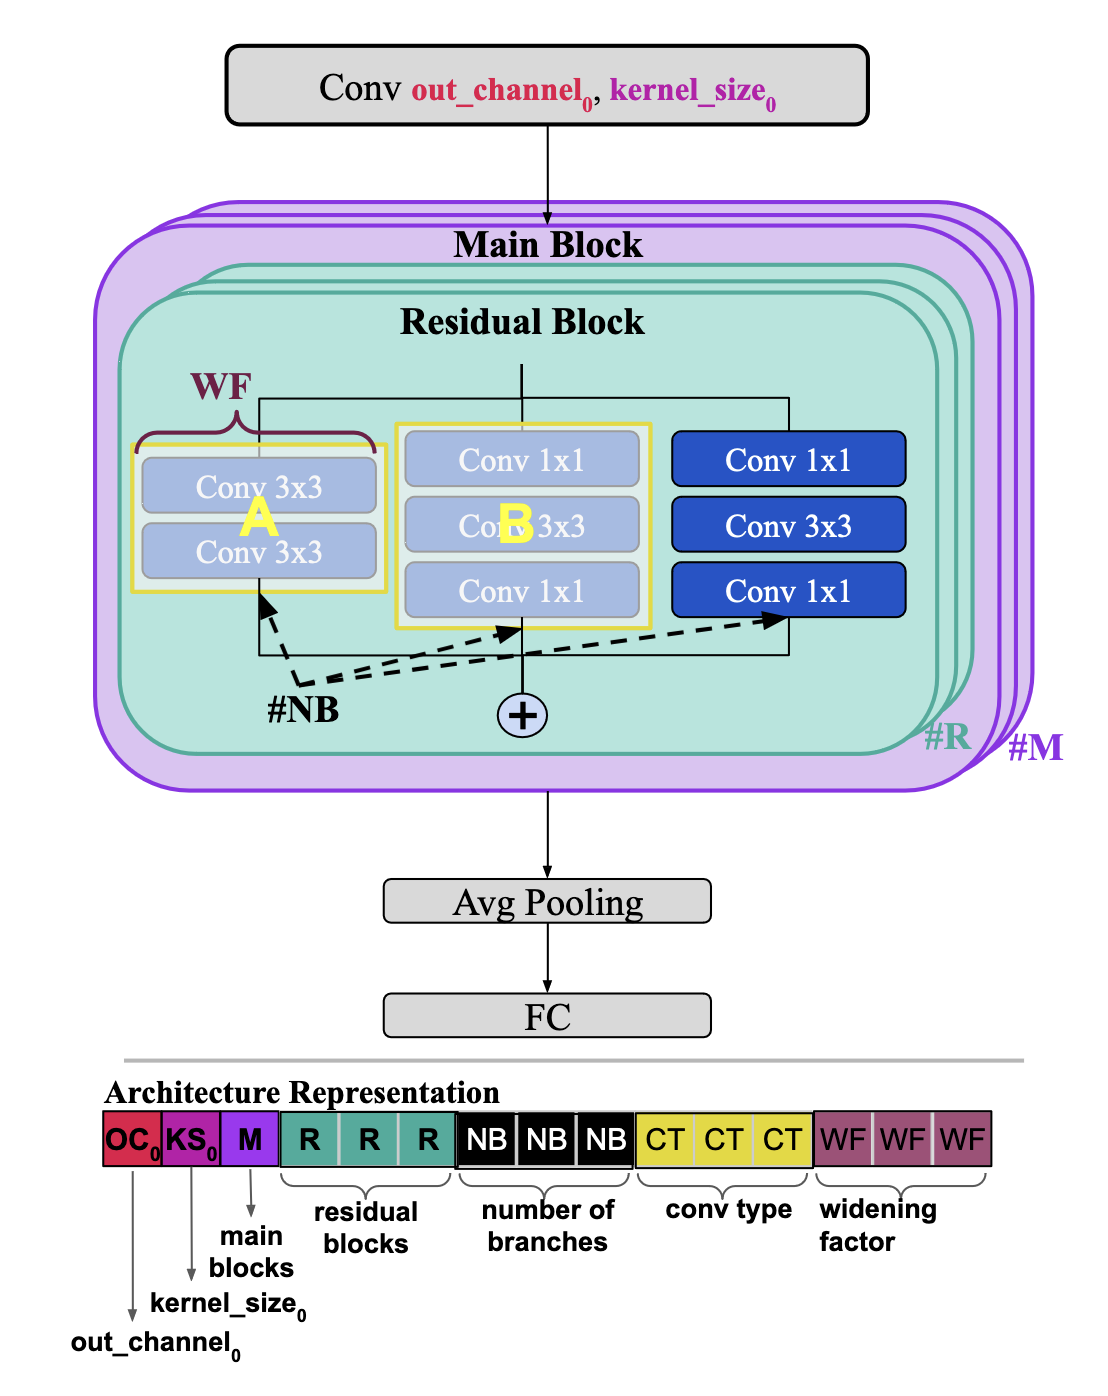

In [3]:
from analogainas.search_spaces.config_space import ConfigSpace

In [4]:
## Default Search Space
CS = ConfigSpace('CIFAR-10')
CS

Architecture Type: resnet-like
Search Space Size: 773094113280
------------------------------------------------
0)
Name: out_channel0
Min_Value:0
Max_value:0
Step:1

1)
Name: M
Min_Value:1
Max_value:5
Step:1

2)
Name: R1
Min_Value:1
Max_value:16
Step:1

3)
Name: R2
Min_Value:0
Max_value:16
Step:1

4)
Name: R3
Min_Value:0
Max_value:16
Step:1

5)
Name: R4
Min_Value:0
Max_value:16
Step:1

6)
Name: R5
Min_Value:0
Max_value:16
Step:1

7)
Name: convblock1
Min_Value:0
Max_value:0
Step:1

8)
Name: widenfact1
Min_Value:0.5
Max_value:0.8
Step:1

9)
Name: B1
Min_Value:1
Max_value:5
Step:1

10)
Name: convblock2
Min_Value:0
Max_value:0
Step:1

11)
Name: widenfact2
Min_Value:0.5
Max_value:0.8
Step:1

12)
Name: B2
Min_Value:1
Max_value:5
Step:1

13)
Name: convblock3
Min_Value:0
Max_value:0
Step:1

14)
Name: widenfact3
Min_Value:0.5
Max_value:0.8
Step:1

15)
Name: B3
Min_Value:1
Max_value:5
Step:1

16)
Name: convblock4
Min_Value:0
Max_value:0
Step:1

17)
Name: widenfact4
Min_Value:0.5
Max_value:0.8
St

In [5]:
# You can extract the full list of hyperparameters using:
CS.get_hyperparameters()

['out_channel0', 'M', 'R1', 'R2', 'R3', 'R4', 'R5', 'convblock1', 'widenfact1', 'B1', 'convblock2', 'widenfact2', 'B2', 'convblock3', 'widenfact3', 'B3', 'convblock4', 'widenfact4', 'B4', 'convblock5', 'widenfact5', 'B5']


In [6]:
## Add a hyperparameter
## Name should be a unique ID.
CS.add_hyperparameter("out_channel", "discrete", min_value=8, max_value=32, step=3)

In [7]:
# Compute the size of the search space
CS.compute_cs_size()

6184752906240

In [8]:
CS.remove_hyperparameter("out_channel")
CS.compute_cs_size()

773094113280

In [9]:
# Sample possible configurations
configs = CS.sample_arch_uniformly(5)

In [10]:
# Configs is a dictionary holding 5 possible architectures in our search space.
configs

[{'out_channel0': 8,
  'M': 1,
  'R1': 13,
  'R2': 0,
  'R3': 0,
  'R4': 0,
  'R5': 0,
  'convblock1': 1,
  'widenfact1': 0.6908466389737407,
  'B1': 2,
  'convblock2': 0,
  'widenfact2': 0,
  'B2': 0,
  'convblock3': 0,
  'widenfact3': 0,
  'B3': 0,
  'convblock4': 0,
  'widenfact4': 0,
  'B4': 0,
  'convblock5': 0,
  'widenfact5': 0,
  'B5': 0},
 {'out_channel0': 12,
  'M': 2,
  'R1': 6,
  'R2': 6,
  'R3': 0,
  'R4': 0,
  'R5': 0,
  'convblock1': 1,
  'widenfact1': 0.6565390160811785,
  'B1': 4,
  'convblock2': 1,
  'widenfact2': 0.7536832858378526,
  'B2': 3,
  'convblock3': 0,
  'widenfact3': 0,
  'B3': 0,
  'convblock4': 0,
  'widenfact4': 0,
  'B4': 0,
  'convblock5': 0,
  'widenfact5': 0,
  'B5': 0},
 {'out_channel0': 8,
  'M': 4,
  'R1': 1,
  'R2': 6,
  'R3': 2,
  'R4': 10,
  'R5': 0,
  'convblock1': 2,
  'widenfact1': 0.7861840131898767,
  'B1': 3,
  'convblock2': 1,
  'widenfact2': 0.763737093661782,
  'B2': 2,
  'convblock3': 2,
  'widenfact3': 0.7589036313340662,
  'B3': 1,

## Step 2: Set the Evaluator

To speed up the search, we built a machine learning predictor to evaluate the accuracy and robustness of any given architecture from the configuration space.

In [11]:
# Load the evaluator
from analogainas.evaluators.xgboost import XGBoostEvaluator
evaluator = XGBoostEvaluator()

In [12]:
# The ranker model ranks the architectures according to their 1-day accuracy. It is trained with a listwise training loss.
evaluator.ranker

XGBRegressor(base_score='8.5658985E-1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
# The AVM predictor regresses the average monthly variation.
evaluator.avm_predictor

XGBRegressor(base_score='9.32594E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Step 3: Search Optimizer and Worker
In this lab, we will use evolutionary search to look for the best architecture in CS using our evaluator.

The overall search process used by analogAINAS is as follows:
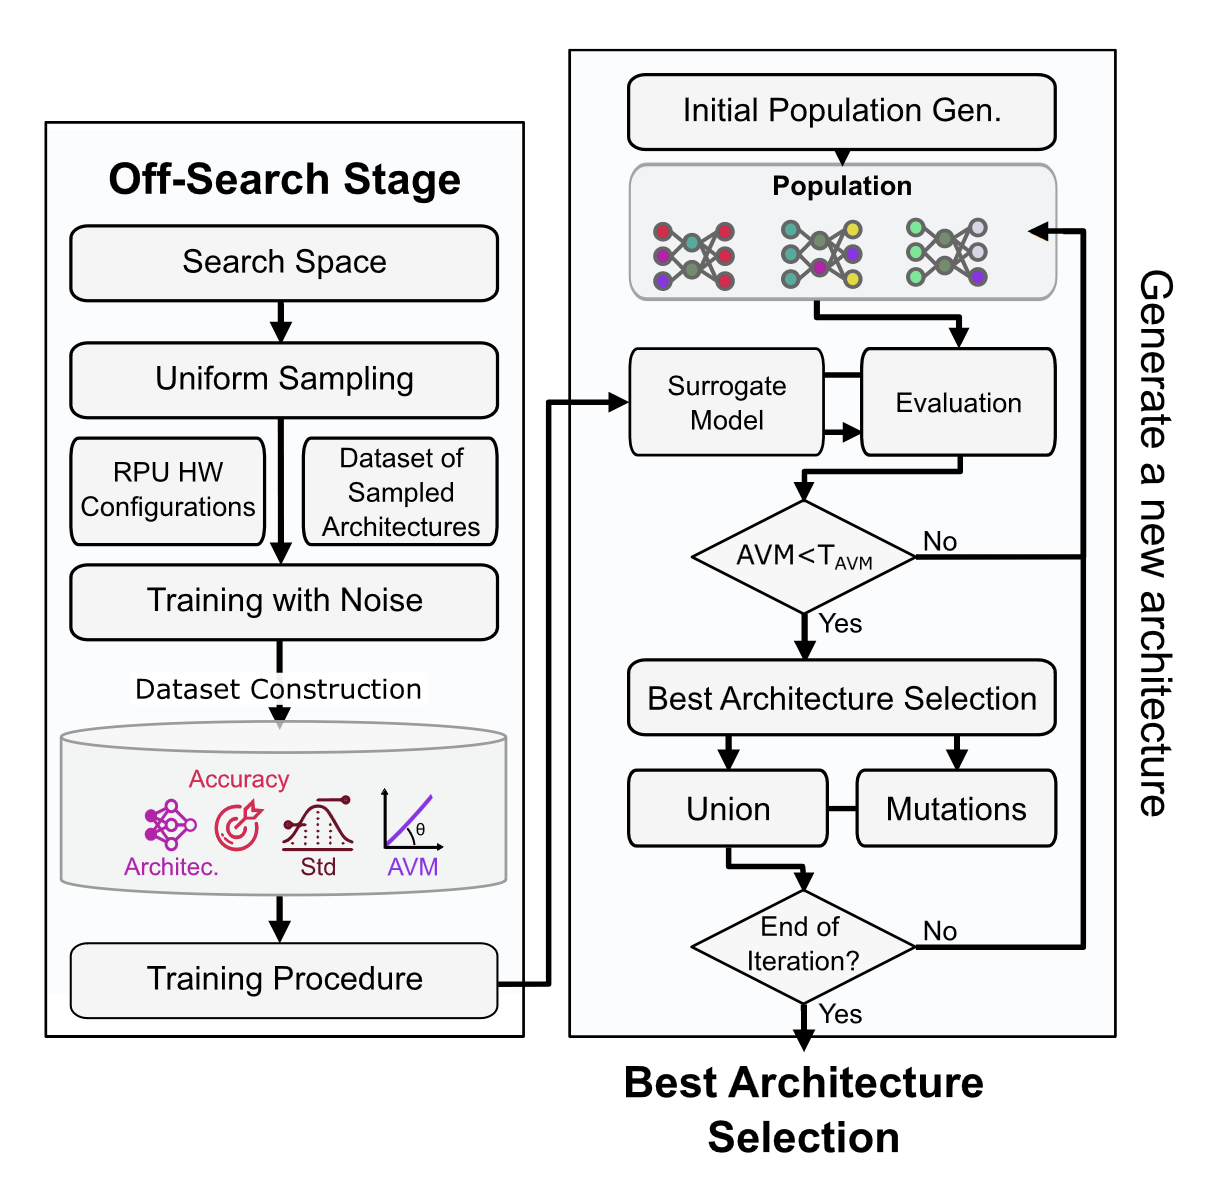


In AnalogAINAS:


*   **EAOptimizer:** runs evolutionary algorithm with the selected search space and evaluator.
*   **Worker:** runs multiple times the EAOptimizer and extracts the results.




In [14]:
from analogainas.search_algorithms.ea_optimized import EAOptimizer
from analogainas.search_algorithms.worker import Worker


In [18]:
NB_RUN = 5

optimizer = EAOptimizer(evaluator, population_size=20, nb_iter=10)
worker = Worker(CS, optimizer=optimizer, runs=NB_RUN)

In [19]:
worker.search()

The 'results' directory already exists.

Search 0 started
2
ITERATION 0 completed: best acc [0.7480494]
ITERATION 1 completed: best acc [0.7480494]
ITERATION 2 completed: best acc [0.9474212]
ITERATION 3 completed: best acc [0.9474212]
ITERATION 4 completed: best acc [0.9474212]
ITERATION 5 completed: best acc [0.9474212]
ITERATION 6 completed: best acc [0.9474212]
ITERATION 7 completed: best acc [0.9474212]
ITERATION 8 completed: best acc [0.9474212]
ITERATION 9 completed: best acc [0.9474212]
Best Acc = [0.9474212]
Search 1 started
2
ITERATION 0 completed: best acc [0.9442333]
ITERATION 1 completed: best acc [0.9442333]
ITERATION 2 completed: best acc [0.9442333]
ITERATION 3 completed: best acc [0.9442333]
ITERATION 4 completed: best acc [0.9442333]
ITERATION 5 completed: best acc [0.9442333]
ITERATION 6 completed: best acc [0.9442333]
ITERATION 7 completed: best acc [0.9442333]
ITERATION 8 completed: best acc [0.9442333]
ITERATION 9 completed: best acc [0.9442333]
Best Acc = [0.9442

In [20]:
worker.result_summary()

Best architecture accuracy:  [0.9806803]
Standard deviation of accuracy over 5 runs: 0.009668926102928877
Best architecture:  {'out_channel0': 12, 'M': 4, 'R1': 3, 'R2': 2, 'R3': 0, 'R4': 3, 'R5': 0, 'convblock1': 1, 'widenfact1': 0.6678630624951394, 'B1': 3, 'convblock2': 2, 'widenfact2': 0.7645261432799274, 'B2': 1, 'convblock3': 2, 'widenfact3': 0.6605427081799845, 'B3': 1, 'convblock4': 1, 'widenfact4': 0.5282750895121485, 'B4': 2, 'convblock5': 0, 'widenfact5': 0, 'B5': 0}
